# Getting Started with `feems`

This notebook illustrates a minimal example of how to run `feems` on a dataset of North American gray wolves published in [Schweizer et al. 2015](https://onlinelibrary.wiley.com/doi/full/10.1111/mec.13364?casa_token=idW0quVPOU0AAAAA%3Ao_ll85b8rDbnW3GtgVeeBUB4oDepm9hQW3Y445HI84LC5itXsiH9dGO-QYGPMsuz0b_7eNkRp8Mf6tlW).

## Imports

First we import the required packages and `feems`:

In [1]:
# base
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

## Data

Note we have packaged this example dataset in the `feems` package and use the `pkg_resources` package to find the path of those files:

In [2]:
data_path = pkg_resources.resource_filename("feems", "data/")

Next we read the `plink` formatted genotype data and impute any missing SNPs with the mean at each SNP:

In [3]:
# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

Mapping files: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 45.28it/s]

n_samples=111, n_snps=17729


As we can see we have 111 samples and 17,729 SNPs. For preparing the graph inputs to run `feems` you have two options:

* Prepare your own input files
* Use the `feems` function `prepare_graph_inputs` which intersects a discrete global grid (DGG) with the sample range

We'll show off the later option. We read the sample coordinates, coordinates of the outer polygon that defines the habitat of the sample and a discrete global grid file which has laid down a triangular grid that is uniformly spaced on earth. We then intersect this global grid with the outer file to define the graph that we use to optimize:

In [4]:
%%time
# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

CPU times: user 5.3 s, sys: 85.5 ms, total: 5.39 s
Wall time: 5.43 s


Lets take a peek at each of these inputs:

In [5]:
outer[:5, ]

array([[-126.2547116,   48.6329086],
       [-127.5731488,   49.1817034],
       [-128.9351421,   50.1205781],
       [-130.2099765,   50.930738 ],
       [-131.8797738,   51.8900539]])

In [6]:
edges[:5, ]

array([[838, 839],
       [357, 386],
       [605, 637],
       [536, 537],
       [136, 158]])

In [7]:
grid[:5, ]

array([[-166.637,   59.732],
       [-166.585,   60.675],
       [-166.529,   61.623],
       [-168.75 ,   62.088],
       [-166.467,   62.576]])

## Setup the `SpatialGraph` object

We then setup the `SpatialGraph` object which is the core workhorse of `feems`. `SpatialGraph` specifies the graph, allele frequency data, and runs the optimizers to fit the edge weights of the graph:

In [8]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

CPU times: user 1min 56s, sys: 3.67 s, total: 1min 59s
Wall time: 2min


This might take a few minutes to construct at first b/c it initializing a number of graph matrices that are slow to build. First, before any fitting we'll visualize the graph and samples. Lets setup the projection we'll be using for this dataset:

In [9]:
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)

Now lets make a map of the sample coordinates, graph and observed nodes:

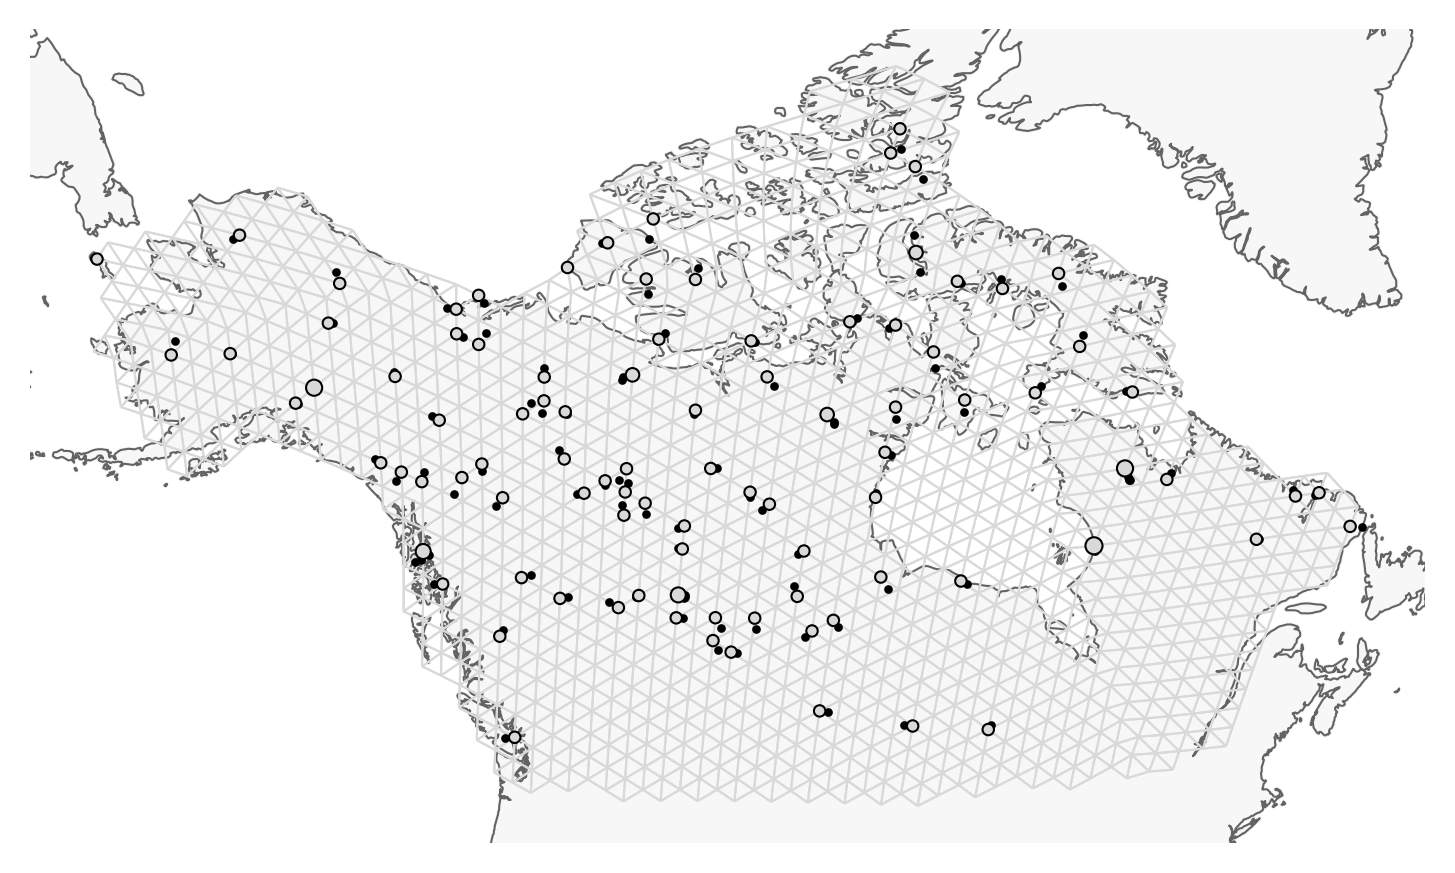

In [10]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

The black points are the observed locations for each sample and the gray points show the nodes that samples were assigned to. The gray lines represent the graph that will be fitted.

## Fit `feems`

Next we fit a the `feems` model where we allow a weight to be estimated for every edge, which is encoded in a large adjacency matrix $\mathbf{W}$, while encouraging nearby edges to be smooth. We initialize at the fit from the null model and fix the estimate of the residual variance for the more complex optimization:

In [11]:
%%time
sp_graph.fit(lamb = 20.0)

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=20.0000000, alpha=0.8354260, converged in 63 iterations, train_loss=2783594.6685242
CPU times: user 6.02 s, sys: 995 ms, total: 7.01 s
Wall time: 1.82 s


Now we can visualize the weighted graph:

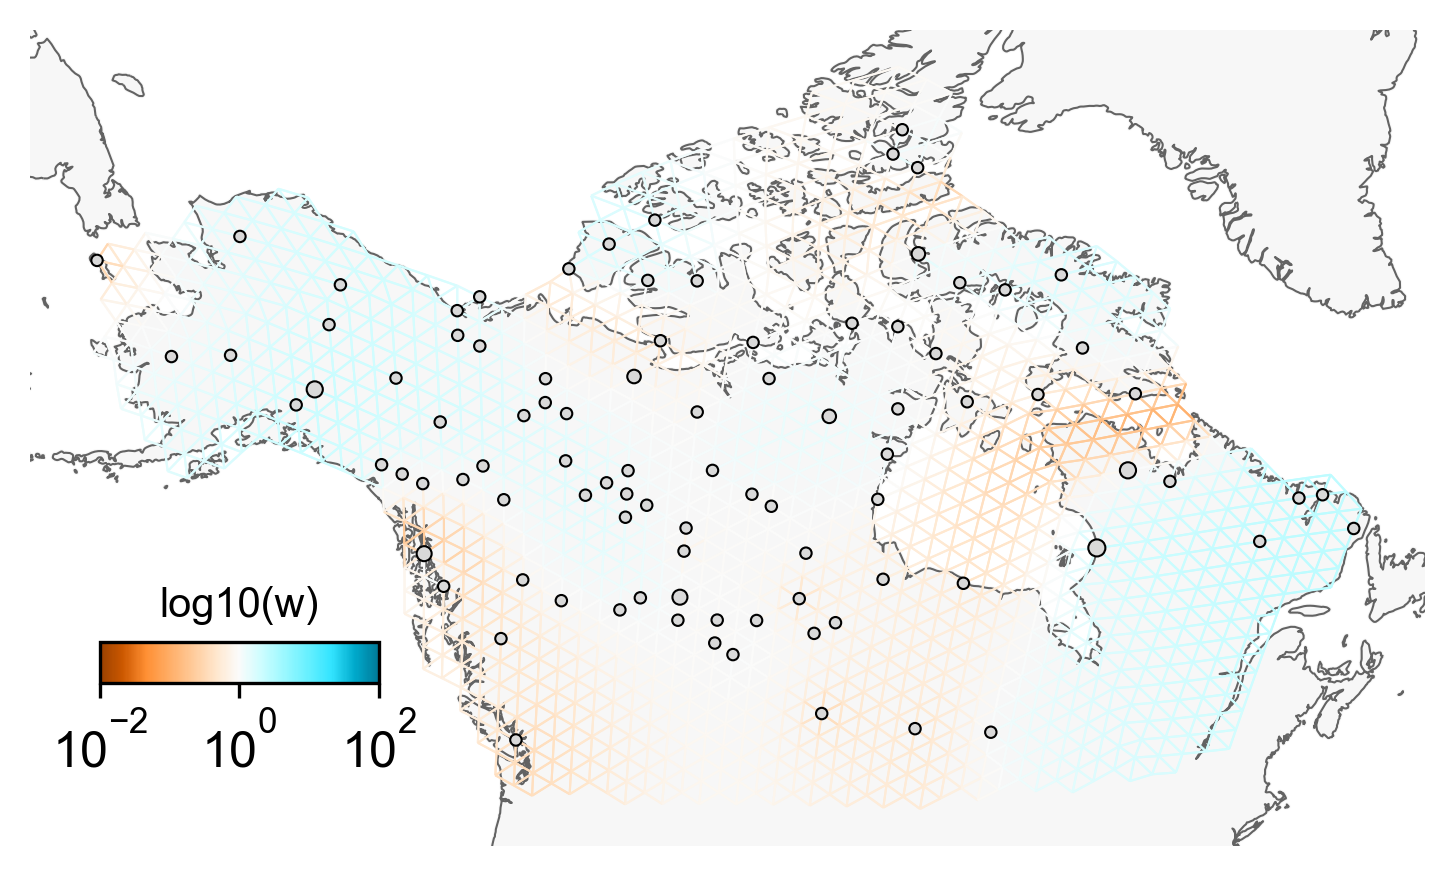

In [12]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

Lets now try a different regularization setting that isn't as smooth:

In [13]:
%%time
sp_graph.fit(lamb = 2.0)

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=2.0000000, alpha=0.8354260, converged in 86 iterations, train_loss=2767069.6406216
CPU times: user 7.76 s, sys: 1.32 s, total: 9.07 s
Wall time: 2.38 s


Make the viz:

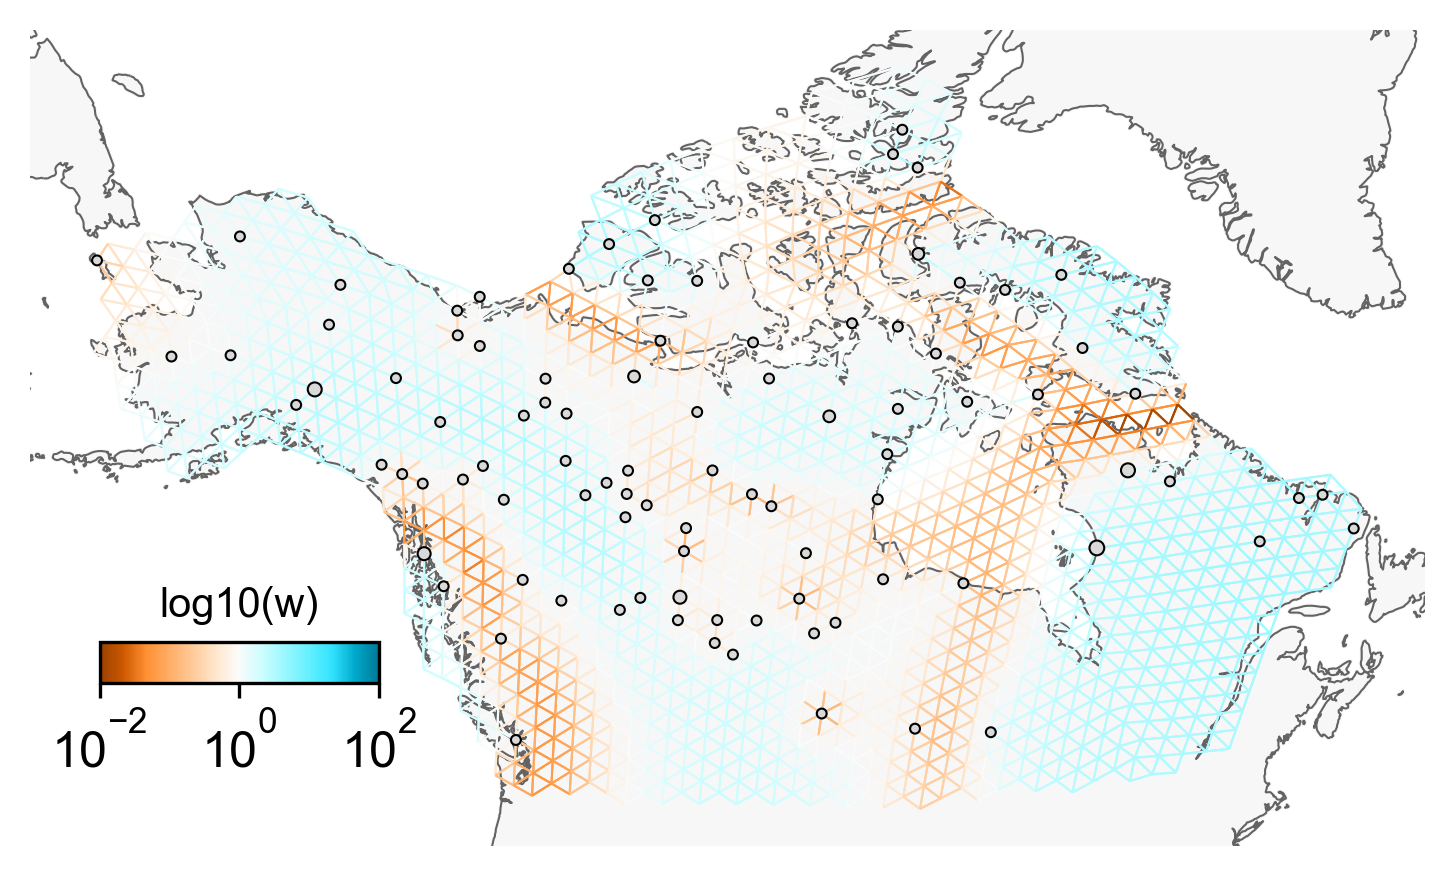

In [18]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

Great ... now we see our first `feems` plot! We essentially provided these results interactively! For more interpretation of these  figures and method please see our pre-print :)